In [ ]:
!pip install ufal.pybox2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 71.6 MB/s eta 0:00:00


In [ ]:

!pip3 install gym[Box_2D]
import gym


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import keras as K
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import gym
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity  = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    #render_mode='human'
)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
episodes = 50
scores = []
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        #print('action :',action)
        next_state, reward, done, info = env.step(action)
        states.append(next_state)
        #print('reward: ',reward)
        score+=reward
    scores.append(score)
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Random Agent')

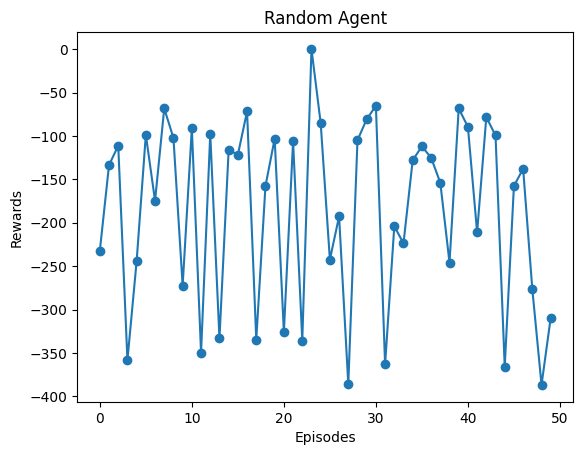

In [ ]:
plt.plot(scores,marker='o')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Random Agent')

In [ ]:
print(next_state.shape)
print(next_state)
print(env.action_space.)
print(env.observation_space)

(8,)
[-0.85127246  0.01835855 -1.7810284  -0.8399213   1.5454624   6.0478525
  0.          1.        ]
<bound method Discrete.contains of Discrete(4)>
Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **DQN**

In [ ]:
def get_model() :

  model = K.Sequential()
  #model.add(K.layers.Dense(512,activation='relu',input_dim=8,name='l1'))
  # model.add(K.layers.Dropout(0.5))
  # model.add(K.layers.BatchNormalization())
  #model.add(K.layers.Dense(256,activation='relu',input_dim=8,name='l2'))
  #model.add(K.layers.Dropout(0.5))
  #model.add(K.layers.BatchNormalization())
  model.add(K.layers.Dense(128,activation='relu',input_dim=8,name='l1'))
  model.add(K.layers.Dense(64,activation='relu',name='l2'))
  model.add(K.layers.Dense(4,activation='linear'))
  opt = K.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt,loss=K.losses.huber_loss)

  return model


In [ ]:
def take_action(model,state,eps):
  eps = eps
  if np.random.rand() < eps :
    action = env.action_space.sample()

  else:
    val = model.predict_on_batch(state)
    action = np.argmax(val)
    
  return action

In [ ]:
def memory(mem_size=500000,input_dims=[8]):
  mem_state = np.zeros((mem_size,*input_dims))
  mem_action = np.zeros(mem_size)
  mem_reward = np.zeros(mem_size)
  mem_new_state = np.zeros((mem_size,*input_dims))
  mem_terminal = np.zeros(mem_size)
  return mem_state, mem_action, mem_reward, mem_new_state, mem_terminal

In [ ]:

mem_size = 500000
def sample_and_learn(mem_state, mem_action, mem_reward, mem_new_state, mem_terminal, model, target, mem_cnt, batch_size=64):
  #print('mem_count',mem_count)
  #print('batch_size',batch_size)
  gamma = 0.99
  if mem_cnt < batch_size :
    return model
  total = min(mem_cnt,mem_size)
  batch = np.random.choice(total,batch_size,replace=False)

  sample_mem_state = mem_state[batch]
  #print('state : ',sample_mem_state.shape)
  sample_mem_action = mem_action[batch].astype('int32')
  #print('action : ',sample_mem_action.shape)
  sample_mem_reward = mem_reward[batch]
  #print('reward : ',sample_mem_reward.shape)
  sample_mem_new_state = mem_new_state[batch]
  #print('new state : ',sample_mem_new_state.shape)
  sample_mem_terminal = mem_terminal[batch]
  #print('terminal : ',sample_mem_terminal.shape)
  batch_idx = np.arange(batch_size,dtype='int32')


  # print('new_state:',mem_new_state)
  q_next = target.predict_on_batch(sample_mem_new_state)
  # print('new_state:',sample_mem_new_state)
  #print('q_next:',q_next.shape)
  # print('reward:',sample_mem_reward)
  # print('terminal:',sample_mem_terminal)
  y_j = sample_mem_reward + gamma*(sample_mem_terminal*np.amax(q_next,axis=1))
  #print('y_j : ',y_j.shape)
  #y_j = y_j.reshape((batch_size,1))
  q_1 = model.predict_on_batch(sample_mem_state)
  #print('q_1 shape : ',q_1.shape)
  #q_1 = q_1.reshape((batch_size,4))
  q_1[batch_idx,sample_mem_action] = y_j
  #print('y_j shape : ',y_j.shape)
  #print('q_1 shape : ',q_1.shape)
  model.fit(sample_mem_state,q_1, epochs = 1, verbose = 0)

  return model

In [ ]:
episodes = 500
scores = []
mem_count = 0
eps_min = 0.05
eps= 1
eps_dec = 0.995
model = get_model()
target = get_model()
target.set_weights(model.get_weights()) 
update_flag = 0 
update_step = 1000
save_flag = 1
mem_state, mem_action, mem_reward, mem_new_state, mem_terminal = memory()
for episode in range(1, episodes+1):
    state = env.reset()
    state = state.reshape(1,8)
    #print(state.shape)
    #print(state)
    done = False
    score = 0 
    
    while not done:
        #env.render()
        flag = True
        action = take_action(model,state, eps)
        #print('action :',action)
        next_state, reward, done, info = env.step(action)
        #print('next_step: ',next_state.shape)
        score+=reward
        
        

        if done == True :
          flag = False

        if mem_count > 500000 :
          mem_count = 0
          print('mem_count reset')
        #print('state:',state.shape)
        mem_state[mem_count] = state
        mem_action[mem_count] = action
        mem_reward[mem_count] = reward
        mem_new_state[mem_count] = next_state
        mem_terminal[mem_count] = flag
        mem_count += 1
        #print('mem_count',mem_count)
        #print('a',next_state)
        #print('b',mem_new_state)
        if update_flag % update_step == 0 :
          target.set_weights(model.get_weights())
          print('target model updated')
        model = sample_and_learn(mem_state, mem_action, mem_reward, mem_new_state, mem_terminal,model,target,mem_count)
        
        state = next_state.reshape(1,8)
        update_flag += 1

        if save_flag % 1000 == 0:
          model.save('dqn_model.h5')
          print('model saved')
          

        save_flag += 1
    eps = eps*eps_dec if eps > eps_min else eps_min
    scores.append(score)
    #print('Episode:{} Score:{}'.format(episode, score))
    score_list = np.array(scores)
    sc_list = pd.DataFrame(score_list)
    sc_list.to_csv('scores_dqn.csv')


# **DDQN**

In [ ]:
def take_action(model,state,eps):
  eps = eps
  if np.random.rand() < eps :
    action = env.action_space.sample()

  else:
    val = model.predict_on_batch(state)
    action = np.argmax(val)
    
  return action

In [ ]:
def get_model() :

  model = K.Sequential()
  #model.add(K.layers.Dense(512,activation='relu',input_dim=8,name='l1'))
  # model.add(K.layers.Dropout(0.5))
  # model.add(K.layers.BatchNormalization())
  model.add(K.layers.Dense(256,activation='relu',input_dim=8,name='l1'))
  #model.add(K.layers.Dropout(0.5))
  #model.add(K.layers.BatchNormalization())
  model.add(K.layers.Dense(128,activation='relu',name='l2'))
  model.add(K.layers.Dense(64,activation='relu',name='l3'))
  model.add(K.layers.Dense(4,activation='linear'))
  opt = K.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt,loss=K.losses.huber_loss)

  return model


In [ ]:

mem_size = 500000
def sample_and_learn(mem_state, mem_action, mem_reward, mem_new_state, mem_terminal, model, target, mem_cnt, batch_size=64):
  #print('mem_count',mem_count)
  #print('batch_size',batch_size)
  gamma = 0.99
  if mem_cnt < batch_size :
    return model
  total = min(mem_cnt,mem_size)
  batch = np.random.choice(total,batch_size,replace=False)

  sample_mem_state = mem_state[batch]
  #print('state : ',sample_mem_state.shape)
  sample_mem_action = mem_action[batch].astype('int32')
  #print('action : ',sample_mem_action.shape)
  sample_mem_reward = mem_reward[batch]
  #print('reward : ',sample_mem_reward.shape)
  sample_mem_new_state = mem_new_state[batch]
  #print('new state : ',sample_mem_new_state.shape)
  sample_mem_terminal = mem_terminal[batch]
  #print('terminal : ',sample_mem_terminal.shape)
  batch_idx = np.arange(batch_size,dtype='int32')


  # print('new_state:',mem_new_state)
  q_next = target.predict_on_batch(sample_mem_new_state)
  q_t = model.predict_on_batch(sample_mem_new_state)
  q_idx = np.argmax(q_t,axis=1).astype('int32')
  #print(q_idx,q_t)
  q_val = q_next[batch_idx,q_idx]
  # print('new_state:',sample_mem_new_state)
  #print('q_next:',q_next.shape)
  # print('reward:',sample_mem_reward)
  # print('terminal:',sample_mem_terminal)
  y_j = sample_mem_reward + gamma*(sample_mem_terminal*q_val)
  #print('y_j : ',y_j.shape)
  #y_j = y_j.reshape((batch_size,1))
  q_1 = model.predict_on_batch(sample_mem_state)
  #print('q_1 shape : ',q_1.shape)
  #q_1 = q_1.reshape((batch_size,4))
  q_1[batch_idx,sample_mem_action] = y_j
  #print('y_j shape : ',y_j.shape)
  #print('q_1 shape : ',q_1.shape)
  model.fit(sample_mem_state,q_1, epochs = 1, verbose = 0)

  return model

In [ ]:

episodes = 650
scores = []
mem_count = 0
eps_min = 0.05
eps= 1
eps_dec = 0.995
model = get_model()
target = get_model()
target.set_weights(model.get_weights()) 
update_flag = 0 
update_step = 1000
save_flag = 1
mem_state, mem_action, mem_reward, mem_new_state, mem_terminal = memory()
for episode in range(1, episodes+1):
    state = env.reset()
    state = state.reshape(1,8)
    #print(state.shape)
    #print(state)
    done = False
    score = 0 
    
    while not done:
        #env.render()
        #flag = True
        action = take_action(model,state,eps)
        #print('action :',action)
        next_state, reward, done, info = env.step(action)
        #print('next_step: ',next_state.shape)
        score+=reward
        
        flag = 1 - done

        if mem_count > 500000 :
          mem_count = 0
          print('mem_count reset')
        #print('state:',state.shape)
        mem_state[mem_count] = state
        mem_action[mem_count] = action
        mem_reward[mem_count] = reward
        mem_new_state[mem_count] = next_state
        mem_terminal[mem_count] = flag
        mem_count += 1
        #print('mem_count',mem_count)
        #print('a',next_state)
        #print('b',mem_new_state)
        if update_flag % update_step == 0 :
          target.set_weights(model.get_weights())
          print('target model updated')
        model = sample_and_learn(mem_state, mem_action, mem_reward, mem_new_state, mem_terminal,model,target,mem_count)
        
        state = next_state.reshape(1,8)
        update_flag += 1

        if save_flag % 1000 == 0:
          model.save('ddqn_model.h5')
          print('model saved')
          

        save_flag += 1

    eps = eps*eps_dec if eps > eps_min else eps_min
    scores.append(score)
    #print('Episode:{} Score:{}'.format(episode, score))
    score_list = np.array(scores)
    sc_list = pd.DataFrame(score_list)
    sc_list.to_csv('scores_ddqn.csv')

In [ ]:
model = K.models.load_model('/content/ddqn_model.h5')
episodes = 50
ddqn_scores = []
q_val = []
for episode in range(1, episodes+1):
    state = env.reset()
    state = state.reshape(1,8)
    done = False
    score = 0 
    q_ep = []
    while not done:
        #env.render()
        q = model.predict_on_batch(state)
        #print(q)
        action = np.argmax(q)
        #print(action)
        q_ep.append(q[0,action])
        #print('action :',action)
        next_state, reward, done, info = env.step(action)
        #print('reward: ',reward)
        score+=reward
        state = next_state.reshape(1,8)
    q_val.append(q_ep)
    ddqn_scores.append(score)
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:177.44947541265316
Episode:2 Score:184.42272537630643
Episode:3 Score:276.5288490538007
Episode:4 Score:272.29103498765085
Episode:5 Score:283.44767180637797
Episode:6 Score:303.86655732899453
Episode:7 Score:270.0368910623421
Episode:8 Score:298.3384390079809
Episode:9 Score:301.5597398980802
Episode:10 Score:304.28534402897174
Episode:11 Score:140.97366159599147
Episode:12 Score:237.35979821853192
Episode:13 Score:278.7420543069214
Episode:14 Score:293.4627500947187
Episode:15 Score:287.0816242259336
Episode:16 Score:304.2110355138348
Episode:17 Score:269.46460594733156
Episode:18 Score:299.8665596394019
Episode:19 Score:265.7424629608318
Episode:20 Score:188.02176657831222
Episode:21 Score:292.32266625520333
Episode:22 Score:299.5049578631769
Episode:23 Score:247.7156224252894
Episode:24 Score:46.73621236082303
Episode:25 Score:303.55105674158574
Episode:26 Score:281.1128632744637
Episode:27 Score:62.77430069354199
Episode:28 Score:295.5272926634434
Episode:29 Score:

In [ ]:
ddqn_q = q_val
ddqn = []
for i in ddqn_q :
  ddqn.append(sum(i))

In [ ]:
model = K.models.load_model('/content/dqn_model.h5')
episodes = 50
dqn_scores = []
q_val = []
for episode in range(1, episodes+1):
    state = env.reset()
    state = state.reshape(1,8)
    done = False
    score = 0 
    q_ep = []
    while not done:
        #env.render()
        q = model.predict_on_batch(state)
        #print(q)
        action = np.argmax(q)
        #print(action)
        q_ep.append(q[0,action])
        #print('action :',action)
        next_state, reward, done, info = env.step(action)
        #print('reward: ',reward)
        score+=reward
        state = next_state.reshape(1,8)
    q_val.append(q_ep)
    dqn_scores.append(score)
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:257.86515106097505
Episode:2 Score:265.08162959788183
Episode:3 Score:254.67326718518348
Episode:4 Score:115.91240849147628
Episode:5 Score:266.8301834874137
Episode:6 Score:266.1444767705393
Episode:7 Score:241.79743400424516
Episode:8 Score:276.3064245010628
Episode:9 Score:251.17110165992793
Episode:10 Score:163.73153474632255
Episode:11 Score:221.8024454791712
Episode:12 Score:259.4471106247459
Episode:13 Score:254.94655017371684
Episode:14 Score:230.50884708545883
Episode:15 Score:239.23845271396152
Episode:16 Score:262.46604715207945
Episode:17 Score:289.4400602530131
Episode:18 Score:279.5130675023931
Episode:19 Score:284.38032631890246
Episode:20 Score:248.3075871442595
Episode:21 Score:92.29251731090324
Episode:22 Score:152.0258731334632
Episode:23 Score:255.66799490655652
Episode:24 Score:234.82838184807784
Episode:25 Score:263.7851904243511
Episode:26 Score:286.5178276232168
Episode:27 Score:250.84178990873463
Episode:28 Score:272.36678774174356
Episode:29 Sc

In [ ]:
dqn_q=q_val
dqn = []
for i in dqn_q:
  dqn.append(sum(i))

In [ ]:
ddqn_avg=sum(ddqn)/50
ddqn_avg = [ ddqn_avg for i in range(50)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dqn_avg = sum(dqn)/50
dqn_avg = [ dqn_avg for i in range(50)]

Text(0, 0.5, 'Q values')

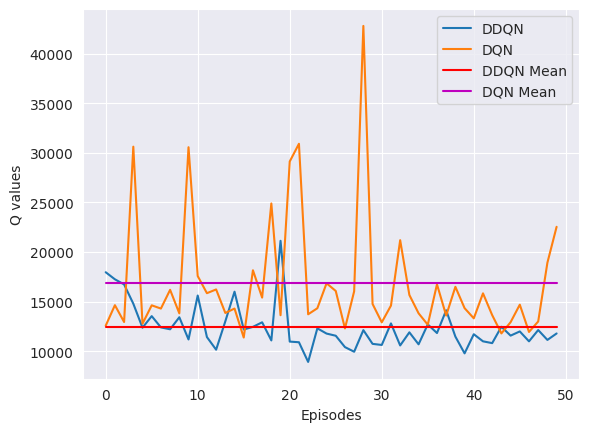

In [ ]:
sns.lineplot(ddqn,label='DDQN')
sns.lineplot(dqn,label='DQN')
sns.lineplot(ddqn_avg,label='DDQN Mean',color='r')
sns.lineplot(dqn_avg,label='DQN Mean',color='m')
plt.xlabel('Episodes')
plt.ylabel('Q values')

DQN mean reward  241.1093157090375
DDQN mean reward  236.00484019042847


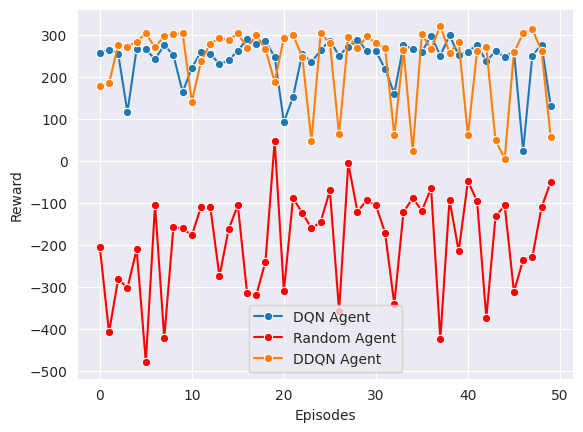

In [ ]:
sns.lineplot(dqn_scores,label='DQN Agent',marker='o')
sns.lineplot(scores,label='Random Agent',color='r',marker='o')
sns.lineplot(ddqn_scores,label='DDQN Agent',marker='o')
plt.xlabel('Episodes')
plt.ylabel('Reward')
print('DQN mean reward ',sum(dqn_scores)/50)
print('DDQN mean reward ',sum(ddqn_scores)/50)

In [ ]:
import seaborn as sns

In [ ]:
dqn = pd.read_csv('/content/scores_dqn.csv')
ddqn = pd.read_csv('/content/scores_ddqn.csv')


In [ ]:
dqn.head()

,scores
0,-90.502429
1,-211.358721
2,-372.781991
3,-85.773730
4,-132.175974


In [ ]:
print(len(dqn),len(ddqn))

500 650


In [ ]:
doc = dqn['scores'].to_numpy()
dqn_avg = []
j = 0
for i in range(100,500):
    dqn_avg.append(doc[j:i].mean())
    j += 1

In [ ]:
doc = ddqn['scores'].to_numpy()
ddqn_avg = []
j = 0
for i in range(100,650):
    ddqn_avg.append(doc[j:i].mean())
    j += 1

Text(0, 0.5, 'Reward')

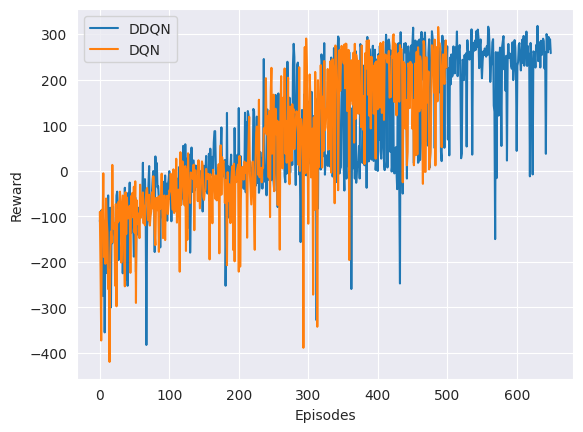

In [ ]:
sns.set_style("darkgrid")

sns.lineplot(ddqn['scores'],label='DDQN')

sns.lineplot(dqn['scores'],label='DQN')
plt.xlabel('Episodes')
plt.ylabel('Reward')

Text(0, 0.5, 'Reward')

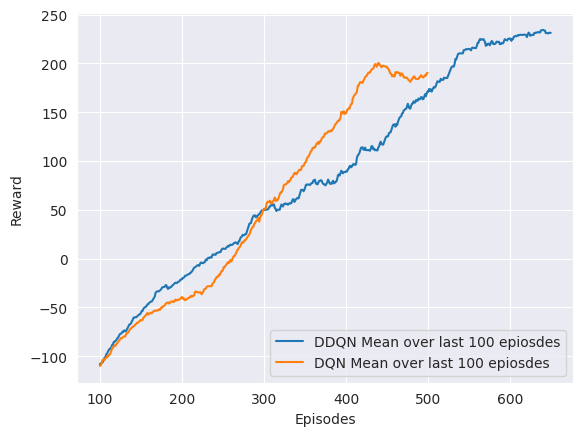

In [ ]:
sns.lineplot(y=ddqn_avg,x=range(100,650),label='DDQN Mean over last 100 epiosdes')
sns.lineplot(y=dqn_avg,x=range(100,500),label='DQN Mean over last 100 epiosdes')
plt.xlabel('Episodes')
plt.ylabel('Reward')